A SVM model for the dataset 

In [1]:
# Import all libraries
from sklearn import model_selection
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets as ds
import seaborn
import sklearn
from sklearn.model_selection import learning_curve

from sklearn.svm import SVC    
from sklearn.feature_selection import RFECV
from sklearn.model_selection import GridSearchCV, cross_val_score,StratifiedKFold
from sklearn import model_selection
from sklearn import metrics
from sklearn import feature_selection 
from sklearn import preprocessing
from sklearn import neighbors
from sklearn import svm
from sklearn import decomposition
from sklearn.impute import KNNImputer
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from hn.load_data import load_data

In [2]:
def plot_learning_curve(estimator, title, X, y, axes, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    axes : array of 3 axes, optional (default=None)
        Axes to use for plotting the curves.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """

    axes.set_title(title)
    if ylim is not None:
        axes.set_ylim(*ylim)
    axes.set_xlabel("Training examples")
    axes.set_ylabel("Score")

    train_sizes, train_scores, test_scores  = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # Plot learning curve
    axes.grid()
    axes.fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes.fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes.plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes.plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes.legend(loc="best")

    return plt

In [14]:

from hn.load_data import load_data
data = load_data()
print(f'The number of samples: {len(data.index)}')
print(f'The number of features: {len(data.columns)-1}')
y_labels = data['label']
del data['label']

y = sklearn.preprocessing.label_binarize(y_labels, ['T12', 'T34']) # 0 now stands for T12 and 1 for T34
y = [i[0] for i in y]
y = np.array(y)

cv_4fold = model_selection.StratifiedKFold(n_splits=4, shuffle=True)
split_X_train, split_X_test, split_y_train, split_y_test = train_test_split(data, y,
                                                    stratify=y, 
                                                    test_size=0.2)
from sklearn.linear_model import LogisticRegression
# Loop over the folds
for training_index, validation_index in cv_4fold.split(split_X_train, split_y_train):
    X_validation = split_X_train.iloc[validation_index]
    y_validation = split_y_train[validation_index]
    X_train = split_X_train.iloc[training_index]
    y_train = split_y_train[training_index]
    #print(f'Validation size in current fold = {len(X_validation)}')

    scaler = preprocessing.StandardScaler()
    # scaler = preprocessing.MinMaxScaler()
    # scaler = preprocessing.RobustScaler()
    scaler.fit(X_train)
    X_test_scaled = scaler.transform(X_validation)
    X_train_scaled = scaler.transform(X_train)
    #apply preprocessing

    n_selected_features = 10
    n_samples = len(X_train.index)
    n_components = min(n_samples, n_selected_features)
    pca = decomposition.PCA(n_components)
    pca.fit(X_train_scaled)
    X_train_pca = pca.transform(X_train_scaled)
    X_validation_pca = pca.transform(X_test_scaled)
    # Modellen proberen 
    grid_param =[{'kernel': ('linear','rbf'), 'gamma': [1e-04, 1e-03, 1e-02, 0.1, 1, 10],'C': [1e-04, 1e-03, 1e-02, 0.1, 1, 10]}]
    grid_search=GridSearchCV(SVC(),grid_param,n_jobs=-1,verbose=2)
    grid_search.fit(X_train_pca, y_train)

    #best_hyperparameters = grid_search.best_params_  
    #print(best_hyperparameters) 
    C = 1 #C = best_hyperparameters.get('C')
    gamma = 0.001 #gamma = best_hyperparameters.get('gamma')
    kernel = 'linear' #kernel = best_hyperparameters.get('kernel')
    #best_result = grid_search.best_score_  
    #print(best_result) 
    
    model=svm.SVC(kernel=kernel, C=C, gamma=gamma)
    model.fit(X_train_pca, y_train)
    #Calculate all class predictions 
    Model_predictions_test=model.predict(X_validation_pca)

    accuracy=metrics.accuracy_score(y_validation, Model_predictions_test)
    print(accuracy)


    #logisticRegr = LogisticRegression(solver = 'lbfgs')
    #logisticRegr.fit(X_train_pca, y_train)
    #Y_pred = logisticRegr.predict(X_validation_pca)
  
    print('#'*80)
    #print(metrics.accuracy_score(y_validation, Y_pred))
    #print(f"Misclassified: {(y_validation != Y_pred).sum()} / {y_validation.shape[0]} ")


The number of samples: 113
The number of features: 159
Fitting 5 folds for each of 72 candidates, totalling 360 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
0.6956521739130435
################################################################################
Fitting 5 folds for each of 72 candidates, totalling 360 fits
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
0.7391304347826086
################################################################################
Fitting 5 folds for each of 72 candidates, totalling 360 fits
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
0.6818181818181818
#######################

In [4]:
# 1. Scaling (standard, min max, robust)
from sklearn.model_selection import GridSearchCV, cross_val_score,StratifiedKFold  


# Apply a grid search to find best of three hyperparameters; kernel, gamma and C. Before feature selection 
grid_param =[{'kernel': ('linear','rbf'), 'gamma': [1e-04, 1e-03, 1e-02, 0.1, 1, 10],'C': [1e-04, 1e-03, 1e-02, 0.1, 1, 10]}]
grid_search=GridSearchCV(SVC(),grid_param,n_jobs=-1,verbose=2)
grid_search.fit(X_train_pca, y_train)

best_hyperparameters = grid_search.best_params_  
print(best_hyperparameters) 
C = best_hyperparameters.get('C')
gamma = best_hyperparameters.get('gamma')
kernel = best_hyperparameters.get('kernel')
best_result = grid_search.best_score_  
print(best_result) 






Fitting 5 folds for each of 72 candidates, totalling 360 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    0.3s
{'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
0.6758241758241758
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:    0.7s finished


In [5]:
model=svm.SVC(kernel=kernel, C=C, gamma=gamma)
model.fit(X_train_pca, y_train)
#Calculate all class predictions 
Model_predictions_test=model.predict(X_validation_pca)

accuracy=metrics.accuracy_score(y_validation, Model_predictions_test)
print(accuracy)





0.6818181818181818


In [6]:
svmlin = SVC(kernel='linear', gamma='scale')
svmrbf = SVC(kernel='rbf', gamma='scale')
svmpoly = SVC(kernel='poly', degree=3, gamma='scale')
clsfs = [svmlin, svmrbf, svmpoly]
for clf in clsfs:
    clf.fit(X_train_pca, y_train)
    y_pred = clf.predict(X_validation_pca)
    print(f"Misclassified: {(y_validation != y_pred).sum()} / {y_validation.shape[0]} ")
    


Misclassified: 6 / 68 
Misclassified: 5 / 68 
Misclassified: 6 / 68 


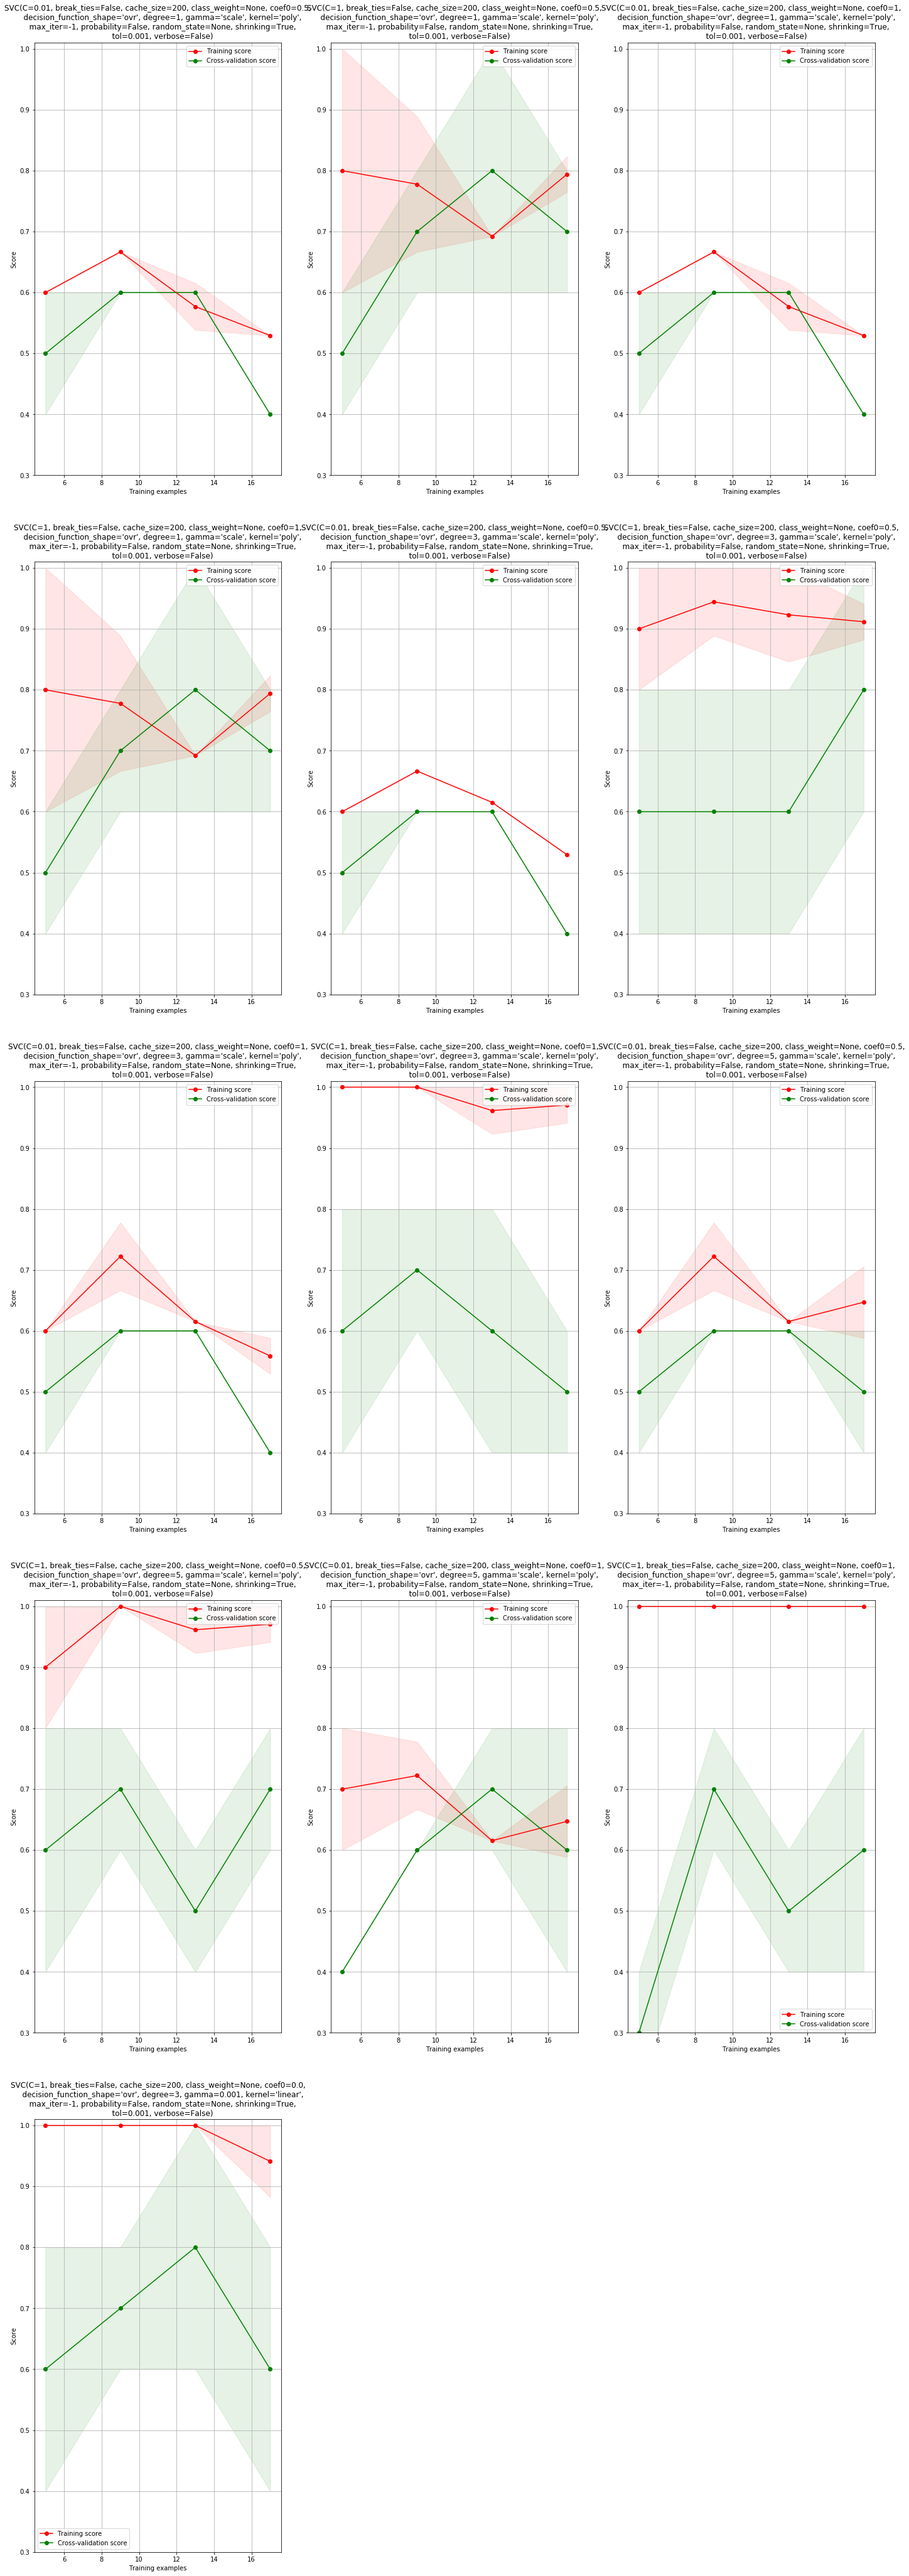

In [9]:
degrees = [1, 3, 5]
coef0s = [0.5, 1]
slacks = [0.01, 1]

clsfs = list()
for degree in degrees:
    for coef0 in coef0s:
        for slack in slacks:
            clsfs.append(SVC(kernel='poly', degree=degree, coef0=coef0, C=slack, gamma='scale'))

C = 1 #C = best_hyperparameters.get('C')
gamma = 0.001 #gamma = best_hyperparameters.get('gamma')
kernel = 'linear' #kernel = best_hyperparameters.get('kernel')

model=svm.SVC(kernel=kernel, C=C, gamma=gamma)
clsfs.append(model)


for clf in clsfs:
    clf.fit(X_train_pca, y_train)
    y_pred = clf.predict(X_validation_pca)
    #print(f"Misclassified: {(y_validation != y_pred).sum()} / {y_validation.shape[0]} ")

fig = plt.figure(figsize=(24,8*len(clsfs)))
cv = model_selection.ShuffleSplit(n_splits=2, test_size=0.2, random_state=0)
num = 0 
for clf in clsfs: 
    title = str(clf)
    ax = fig.add_subplot(7, 3, num + 1)
    plot_learning_curve(clf, title, X_validation_pca, y_validation, ax, ylim=(0.3, 1.01), cv=cv)
    num += 1


